In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SVD 학습
- numpy svd를 활용해 직접 `행렬 분해`를 구현
- `SVD`를 수행하기 위해선 `Rating Matrix`가 모두 채워져 있어야 합니다 $\to$ `Dense Matrix`
    - user average / item average로 채움
- `Latent Factor` 개수에 따라 달라지는 `rmse` 값을 확인합니다.

In [ ]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/ml-latest-small/'

In [ ]:
ratings_df = pd.read_csv(path + 'ratings.csv', encoding='utf-8')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


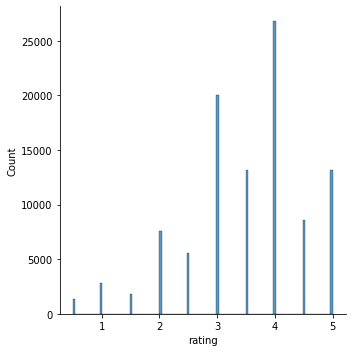

In [ ]:
sns.displot(ratings_df['rating'])

## numpy로 직접 SVD 구현

In [ ]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=10)

print('train_df :', train_df.shape, ', test_df :', test_df.shape)

train_df : (80668, 4) , test_df : (20168, 4)


In [ ]:
user_item_matrix = train_df.pivot_table('rating', 'userId', 'movieId')

- `SVD`를 수행하기 위해서는 빈 entry가 없는 `Dense Matrix`가 되어야 합니다
- 행렬이 비어있는 entry에 유저 혹은 아이템 기준으로 구한 평균 평점을 채워넣습니다

In [ ]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185029,185031,185033,185135,185435,185473,185585,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,4.5,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,2.0,NaN,3.5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 평균 평점으로 채워 넣음 - 유저 평균 평점
user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=1) # axis=0 : index 기준(행), axis=1 : 열 기준(열)

# 평균 평점으로 채워 넣음 - 영화 평균 평점
# user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [ ]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185029,185031,185033,185135,185435,185473,185585,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.000000,4.372973,4.000000,4.372973,4.372973,4.000000,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,...,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973,4.372973
2,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,...,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333,4.083333
3,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,...,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517,2.465517
4,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.000000,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,2.000000,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,...,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989,3.522989
5,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,4.000000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,4.000000,3.500000,3.500000,3.000000,3.500000,3.500000,3.500000,3.500000,...,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,3.500

- numpy에서 제공하는 [SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)

In [ ]:
def calculate_SVD(matrix, k=20):
    # numpy SVD 수행
    u, sig, i = np.linalg.svd(matrix)

    # 유저 매트릭스 가운데 k개 latent factor만 사용
    # u.shape = (610, 610)
    u_hat = u[:, :k]
    print('u_hat :', u_hat.shape)

    # 아이템 매트릭스 가운데 k개 latne factor만 사용
    # i.shape = (9001, 9001)
    i_hat = i[:k, :]
    print('i_hat :', i_hat.shape)

    # 잠재 요인 대각 행렬
    # sig : matrix의 singular value, 가장 큰 값부터 내림차순으로 정렬되어 있음
    # lenght(sig) = min(610, 9001) = 610
    sig_hat = sig[:k] * np.identity(k, np.float) # 행렬 값 float화

    user_factors = u_hat
    item_factors = np.matmul(sig_hat, i_hat)
    
    return user_factors, item_factors


In [ ]:
# 예제
k = 50
user_factors, item_factors = calculate_SVD(user_item_matrix, 50)

u_hat : (610, 50)
i_hat : (50, 9001)


In [ ]:
# 유저 잠재 요인, 아이템 잠재 요인 행렬
print('user_factors :', user_factors.shape, ', item_factors :', item_factors.shape)

user_factors : (610, 50) , item_factors : (50, 9001)


- 두 잠재 요인 행렬을 곱하면 유저-아이템 조합에 대한 예측 평점의 행렬을 구할 수 있습니다


In [ ]:
prediction_result_df = pd.DataFrame(np.matmul(user_factors, item_factors),
                                    columns=user_item_matrix.columns.values, index=user_item_matrix.index.values)

In [ ]:
# train 데이터로 만든 평점 예측 값 R_hat
prediction_result_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185029,185031,185033,185135,185435,185473,185585,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193587,193609
1,4.455760,4.376862,4.445517,4.378512,4.336953,4.230930,4.287235,4.378368,4.379953,4.338540,4.331611,4.377108,4.391719,4.359317,4.363184,4.390866,4.279915,4.387565,4.493591,4.362606,4.427732,4.352392,4.352214,4.302841,4.390785,4.368228,4.374986,4.390186,4.432690,4.364689,4.325035,4.347326,4.321318,4.370756,4.377355,4.296145,4.377229,4.366598,4.370298,4.377639,...,4.370170,4.373932,4.363878,4.375277,4.379778,4.370569,4.370360,4.372861,4.374903,4.370288,4.366956,4.356516,4.361863,4.372243,4.373351,4.376301,4.377261,4.373562,4.371744,4.372760,4.374794,4.338507,4.383248,4.371949,4.377198,4.368109,4.379016,4.377198,4.379016,4.379016,4.374534,4.372675,4.371745,4.373604,4.373604,4.372675,4.373604,4.372675,4.372675,4.373269
2,4.116021,4.093123,4.059365,4.075956,4.089813,4.076023,4.054649,4.081869,4.076706,4.093391,4.063080,4.057914,4.085746,4.079204,4.087732,4.066698,4.082231,4.089004,4.063108,4.070472,4.095819,4.073407,4.101016,4.072113,4.058665,4.080043,4.092581,4.096768,4.103887,4.082954,4.104497,4.057154,4.090061,4.095299,4.086751,4.067778,4.087748,4.086052,4.088641,4.082660,...,4.079655,4.083995,4.077426,4.083648,4.085767,4.081763,4.084692,4.083186,4.077055,4.081231,4.081570,4.082462,4.082742,4.084974,4.082945,4.085505,4.086100,4.083392,4.083178,4.083518,4.081489,4.072165,4.083860,4.084450,4.083820,4.082750,4.084034,4.083820,4.084034,4.084034,4.085951,4.082815,4.081246,4.084383,4.084383,4.082815,4.084383,4.082815,4.082815,4.083071
3,2.489142,2.493289,2.435234,2.471230,2.497086,2.406091,2.466641,2.491103,2.462545,2.481086,2.416361,2.438978,2.468215,2.450856,2.463744,2.433893,2.380089,2.446880,2.553131,2.480213,2.489118,2.457557,2.475471,2.432137,2.400360,2.458727,2.465684,2.471599,2.476933,2.465910,2.498992,2.474013,2.432515,2.467952,2.461193,2.466317,2.469526,2.454159,2.476139,2.472736,...,2.457685,2.465594,2.469113,2.465262,2.468406,2.466473,2.465720,2.465414,2.462471,2.455330,2.470476,2.481939,2.476607,2.470383,2.464902,2.466741,2.463833,2.465740,2.465068,2.465819,2.462511,2.451237,2.455278,2.466249,2.467083,2.463725,2.467754,2.467083,2.467754,2.467754,2.467970,2.465050,2.463590,2.466510,2.466510,2.465050,2.466510,2.465050,2.465050,2.465735
4,3.438885,3.538087,3.404722,3.516883,3.387723,3.323818,3.443567,3.498151,3.554042,3.884841,3.490976,3.537177,3.513757,3.466556,3.522172,3.631705,3.243450,3.541738,3.729583,3.477464,3.511713,3.521525,3.499961,3.207151,3.299429,3.526328,3.525252,3.580570,3.629229,3.510448,3.551675,1.819395,3.630472,3.549422,3.520846,3.355189,3.547600,3.552538,3.512105,3.554307,...,3.608797,3.524106,3.466103,3.518447,3.486472,3.507961,3.523687,3.522839,3.554297,3.599893,3.505967,3.581651,3.562605,3.519763,3.528774,3.534232,3.549820,3.525300,3.518221,3.522306,3.550938,3.393236,3.486424,3.511095,3.539460,3.504062,3.546539,3.539460,3.546539,3.546539,3.524558,3.522719,3.521799,3.523639,3.523639,3.522719,3.523639,3.522719,3.522719,3.526527
5,3.535751,3.476395,3.438381,3.478689,3.454173,3.565401,3.468226,3.491675,3.488108,3.454820,3.532224,3.474371,3.478311,3.510593,3.511035,3.528704,3.564892,3.520706,3.332264,3.474704,3.495521,3.499043,3.504074,3.477149,3.535109,3.502888,3.496196,3.513305,3.504408,3.505034,3.487960,3.627316,3.579008,3.525669,3.489152,3.436737,3.502242,3.516628,3.490955,3.489021,...,3.497125,3.500381,3.491485,3.500187,3.498734,3.497747,3.500562,3.499919,3.489765,3.504137,3.498526,3.489372,3.492824,3.500510,3.498800,3.502180,3.504010,3.499468,3.501117,3.499799,3.494180,3.509335,3.506633,3.502756,3.496169,3.504415,3.494520,3.496169,3.494520,3.494520,3.500828,3.499840,3.499346,3.500334,3.500334,3.499840,3.500334,3

- 다음은 예측 평점을 사용해서 test 데이터를 예측해봅니다

In [ ]:
# test 데이터에 새로 등장하는 유저, 아이템을 위한 global rating
global_rating = train_df['rating'].mean()

In [ ]:
result = []

for _, row in tqdm(test_df.iterrows()):
    # 예측해야하는 유저, 아이템, 평점
    user_id = row['userId']
    movie_id = row['movieId']
    true_rating = row['rating']

    if user_id in prediction_result_df.index.values and movie_id in prediction_result_df.columns.values:
        pred_rating = prediction_result_df.loc[user_id][movie_id]
    else:
        pred_rating = global_rating
    
    result.append([user_id, movie_id, true_rating, pred_rating])

result_df = pd.DataFrame(result, columns=['user_id', 'movie_id', 'true_rating', 'pred_rating'])

20168it [00:04, 4691.30it/s]


In [ ]:
result_df

,user_id,movie_id,true_rating,pred_rating
0,239.0,924.0,4.0,4.106564
1,384.0,2763.0,3.0,2.957313
2,52.0,58559.0,5.0,4.640744
3,600.0,719.0,2.5,3.038116
4,318.0,117364.0,4.0,3.503954
...,...,...,...,...
20163,20.0,5015.0,4.0,3.472314
20164,177.0,6787.0,3.0,3.400911
20165,103.0,969.0,4.0,3.926839
20166,42.0,2875.0,3.0,3.609600


In [ ]:
print('RMSE :', np.sqrt(mean_squared_error(result_df['true_rating'].values, result_df['pred_rating'].values)))

RMSE : 0.9342638634779828


- 오차 값이 1에 가까우므로 정확도가 높다고 할 수 없습니다

## SVD의 적합한 k 찾기
- `SVD`를 수행할 때 사용하는 잠재요인의 숫자는 사용자가 정하는 하이퍼 파라미터입니다
- `k`에 따라 학습 성능과 예측 성능이 얼마나 달라지는지 실험해 봅니다

In [ ]:
# 사용자 평균 평점으로 빈 entry를 채움
user_item_matrix = train_df.pivot_table('rating', 'userId', 'movieId')
user_item_matrix = user_item_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

In [ ]:
global_rating = train_df['rating'].mean()

In [ ]:
train_result, test_result = [], []

# k에 따라서 모델을 학습하고 평가함
for k in tqdm(np.arange(2, 20, 2)):
    # 모델 학습 및 평균 추론
    user_factors, item_factors = calculate_SVD(user_item_matrix, k)
    prediction_result_df = pd.DataFrame(np.matmul(user_factors, item_factors),
                                        columns=user_item_matrix.columns.values, index=user_item_matrix.index.values)

    # 학습 데이터 평가
    pred_rating, true_rating = [], []
    for _, row in train_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        true_rating.append(row['rating'])

        if user_id in user_item_matrix.index.values and movie_id in user_item_matrix.columns.values:
            pred_rating.append(prediction_result_df.loc[user_id][movie_id])
        else:
            pred_rating.append(global_rating)

    rmse = np.sqrt(mean_squared_error(np.asarray(true_rating), np.asarray(pred_rating)))
    train_result.append([k, rmse])

    # 테스트 데이터 평가
    pred_rating, true_rating = [], []
    for _, row in test_df.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        true_rating.append(row['rating'])

        if user_id in user_item_matrix.index.values and movie_id in user_item_matrix.columns.values:
            pred_rating.append(prediction_result_df.loc[user_id][movie_id])
        else:
            pred_rating.append(global_rating)

    rmse = np.sqrt(mean_squared_error(np.asarray(true_rating), np.asarray(pred_rating)))
    test_result.append([k, rmse])

k_train_result_df = pd.DataFrame(train_result, columns=['k', 'rmse'])
k_test_result_df = pd.DataFrame(test_result, columns=['k', 'rmse'])


  0%|          | 0/9 [00:00<?, ?it/s]

u_hat : (610, 2)
i_hat : (2, 9001)


 11%|█         | 1/9 [00:38<05:07, 38.43s/it]

u_hat : (610, 4)
i_hat : (4, 9001)


 22%|██▏       | 2/9 [01:16<04:28, 38.42s/it]

u_hat : (610, 6)
i_hat : (6, 9001)


 33%|███▎      | 3/9 [01:55<03:50, 38.40s/it]

u_hat : (610, 8)
i_hat : (8, 9001)


 44%|████▍     | 4/9 [02:33<03:11, 38.37s/it]

u_hat : (610, 10)
i_hat : (10, 9001)


 56%|█████▌    | 5/9 [03:11<02:33, 38.35s/it]

u_hat : (610, 12)
i_hat : (12, 9001)


 67%|██████▋   | 6/9 [03:49<01:54, 38.29s/it]

u_hat : (610, 14)
i_hat : (14, 9001)


 78%|███████▊  | 7/9 [04:28<01:16, 38.30s/it]

u_hat : (610, 16)
i_hat : (16, 9001)


 89%|████████▉ | 8/9 [05:06<00:38, 38.30s/it]

u_hat : (610, 18)
i_hat : (18, 9001)


100%|██████████| 9/9 [05:45<00:00, 38.34s/it]


- `train` 데이터와 `test` 데이터 평가표를 작성합니다

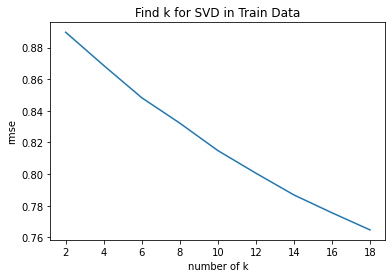

In [ ]:
plt.plot(k_train_result_df.k, k_train_result_df.rmse)
plt.title('Find k for SVD in Train Data')
plt.xlabel('number of k', fontsize=10)
plt.ylabel('rmse')
plt.show()

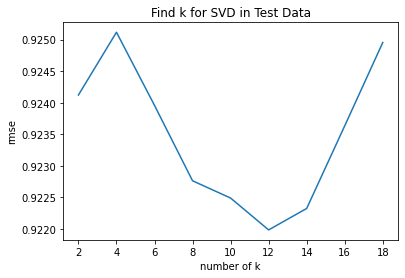

In [ ]:
plt.plot(k_test_result_df.k, k_test_result_df.rmse)
plt.title('Find k for SVD in Test Data')
plt.xlabel('number of k', fontsize=10)
plt.ylabel('rmse')
plt.show()

- `train` 데이터를 보면 `k`가 증가할 수록 점점 오차가 줄어드는 것을 확인(이후 증가할 수록 오차가 줄어드는 것까진...)
- 학습한 모델을 기반으로 `test` 데이터에 적용해본 결과 `k` = 12 일때가 가장 오차가 적음을 확인할 수 있습니다

# Matrix Factorization의 SGD 구현

- `SGD` 최적화를 이용해 `MF` 모델의 파라미터를 업데이트합니다
- 유저, 아이템 `bias`까지 추가된 모델로 구현합니다

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 228kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617603 sha256=9a50665280e915b40af30b76c1cdced1aafced27d497faf1380711adac423254
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from surprise import KNNBasic, KNNWithMeans, SVD
from surprise.model_selection.validation import cross_validate

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/ml-latest-small/'

In [ ]:
# 무비렌즈 학습 데이터
ratings_df = pd.read_csv(path + 'ratings.csv', encoding='utf-8')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


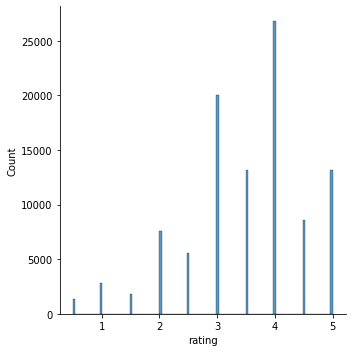

In [ ]:
sns.displot(ratings_df['rating'])

## MF 구현

In [ ]:
# 학습 데이터, 하이퍼 파라미터 초기화

# 유저 아이템의 Rating 매트릭스
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)

# numpy 변환
R = user_item_matrix.to_numpy()

# 잠재 요인의 수
K = 20
learning_rate = 0.01

# L2 정규화 파라미터
regularization = 0.2

# 학습 데이터의 반복 횟수
epochs = 20

num_users, num_items = user_item_matrix.shape

In [ ]:
# 학습 파라미터 초기화

# 평균이 0, 표준편차는 1/K로 랜덤하게 초기화
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

# bias 초기화
# 유저
b_u = np.zeros(num_users)
# 아이템
b_i = np.zeros(num_items)
# 전체
b = np.mean(R[np.where(R != 0)])

In [ ]:
R.shape

(610, 9724)

- 학습 데이터를 구성합니다
- 실제 평가를 내린 데이터만 학습에 사용합니다

In [ ]:
samples = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]

In [ ]:
# 총 학습 데이터 사이즈
print(len(samples))
print(samples[123])

100836
(0, 1515, 4.0)


- Parameter Update

 $ b_{u} \gets b_{u} + \gamma \cdot (e_{ui} - \lambda b_{u})$

 $ b_{i} \gets b_{i} + \gamma \cdot (e_{ui} - \lambda b_{u})$

 $ p_{u} \gets p_{u} + \gamma \cdot (e_{ui}q_{i} - \lambda p_{u})$
 
 $ q_{i} \gets q_{i} + \gamma \cdot (e_{ui}p_{u} - \lambda q_{i})$

In [ ]:
# SGD를 활용한 파라미터 업데이트

training_result = []

for epoch in range(epochs):
    
    # 학습 데이터 순서를 셔플링 -> 다른 순서로 학습하기 때문에 수렴이 더 잘됨, 매 epoch마다 수행
    np.random.shuffle(samples)
    
    for i, j, r in samples:
        
        # 현재 주어진 파라미터로 predicted rating을 구함
        prediction = b + b_u[i] + b_i[j] + P[i, :].dot(Q[j, :].T)
        # 실제 rating과 predicted rating의 차이가 error
        e = (r - prediction)

        # 유저, 아이템 bias 파라미터를 업데이트
        b_u[i] += learning_rate * (e - regularization * b_u[i])
        b_i[j] += learning_rate * (e - regularization * b_i[j])

        # 유저, 아이템 잠재 행렬 파라미터를 업데이트
        P[i, :] += learning_rate * (e * Q[j, :] - regularization * P[i,:])
        Q[j, :] += learning_rate * (e * P[i, :] - regularization * Q[j,:])
        
    
    # 학습이 모두 끝나고 학습 데이터를 활용해 training loss를 구합니다
    ut, it = R.nonzero()
    predicted_R = b + b_u[:,np.newaxis] + b_i[np.newaxis:,] + P.dot(Q.T) # add new axis, dimension 1 => 2
    error = []
    for x, y in zip(ut, it):
        error.append(pow(R[x, y] - predicted_R[x, y], 2))
    rmse = np.sqrt(np.asarray(error).mean())
    print(epoch + 1, rmse)
    training_result.append([epoch+1, rmse])

training_result_pd = pd.DataFrame(training_result, columns = ['iteration', 'rmse'])

1 0.8987734725850418
2 0.8765219870313813
3 0.8657237275588345
4 0.8580962580228283
5 0.8516159088619986
6 0.8473326250283169
7 0.8436341502124597
8 0.8396954196505734
9 0.8371266690793063
10 0.8348570033204409
11 0.8324314213578037
12 0.8310303993772481
13 0.8296246469568297
14 0.8276901453634067
15 0.8260867626575938
16 0.8246001059364907
17 0.8236580114878583
18 0.8226641994613231
19 0.8217277467484619
20 0.8209700599542857


In [ ]:
training_result_pd

,iteration,rmse
0,1,0.898773
1,2,0.876522
2,3,0.865724
3,4,0.858096
4,5,0.851616
5,6,0.847333
6,7,0.843634
7,8,0.839695
8,9,0.837127
9,10,0.834857


## MF Class
- 앞서 구한 `MF`를 `SGD`로 학습하는 것을 `class` 형태로 제작

In [ ]:
import numpy as np

class MF():
    def __init__(self, R, K, learning_rate, regularization, iterations):
        """
        Arguments
        - R (ndarray)               : 유저 아이템 매트릭스
        - K (int)                   : Latent Vector 차원
        - learning_rate(float)      : Learning rate
        - Regularization(float)     : 정규화 파라미터
        """
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.iterations = iterations

    def train(self):
        # 유저-아이템의 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale = 1. / self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale = 1. / self.K, size=(self.num_items, self.K))

        # 유저, 아이템, 글로벌 bias 초기화
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # 학습 데이터 생성
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # iteration 개수만큼 전체 데이터에 대해서 SGD 수행
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)

            self.sgd()
            rmse = self.rmse()

            training_process.append((i, rmse))

            if (i + 1) % 10 == 0:
                print('Iteration: %d, error = %.4f' % (i + 1, rmse))

        return pd.DataFrame(training_process, columns =['Iteration', 'RMSE'])

    def rmse(self):
        """
        전체 학습 데이터에 대한 RMSE 계산
        """
        ut, it = self.R.nonzero()
        predicted_R = self.full_matrix()
        error = []
        for x, y in zip(ut, it):
            error.append(pow(R[x,y] - predicted_R[x, y], 2))
        return np.sqrt(np.asarray(error).mean())

    def sgd(self):
        """
        SGD로 파라미터 업데이트가 되는 함수
        """
        for i, j, r in self.samples:
            # True Rating과 Predicted Rating을 구하고 Error를 구함
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Bias 업데이트
            self.b_u[i] += self.learning_rate * (e - self.regularization * self.b_u[i])
            self.b_i[j] += self.learning_rate * (e - self.regularization * self.b_i[j])

            # 유저, 아이템 잠재 요인 행렬 업데이트
            self.P[i, :] += self.learning_rate * (e * self.Q[j, :] - self.regularization * self.P[i, :])
            self.Q[j, :] += self.learning_rate * (e * self.P[i, :] - self.regularization * self.Q[j, :])

    def get_rating(self, i, j):
        """
        유저 i, 아이템 j에 대한 예측 평점
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        예측된 유저 아이템 매트릭스 계산 -> Rhat
        """
        return self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
    

In [ ]:
# 주어진 유저-아이템 매트릭스

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

mf = MF(R, K=2, learning_rate=0.1, regularization=0.01, iterations=30)

In [ ]:
# MF 모델 학습
train_result_df = mf.train()

Iteration: 10, error = 0.0310
Iteration: 20, error = 0.0113
Iteration: 30, error = 0.0107


In [ ]:
# 예측 매트릭스
mf.full_matrix()

array([[4.98560653, 3.00235984, 4.04517694, 1.01044314],
       [3.99521215, 2.43011952, 3.09642614, 1.01053433],
       [1.00597503, 1.00885036, 3.11403436, 4.98151972],
       [1.0150191 , 0.17900123, 3.91146141, 3.99635713],
       [2.31438517, 1.01293824, 4.98870944, 3.99310694]])

## 무비렌즈 데이터로 학습

In [ ]:
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)
R = user_item_matrix.to_numpy()
K = 20
learning_rate = 0.01
regularization = 0.2

mf = MF(R, K, learning_rate, regularization, iterations=30)

In [ ]:
train_result_df = mf.train()

Iteration: 10, error = 0.8343
Iteration: 20, error = 0.8204
Iteration: 30, error = 0.8126


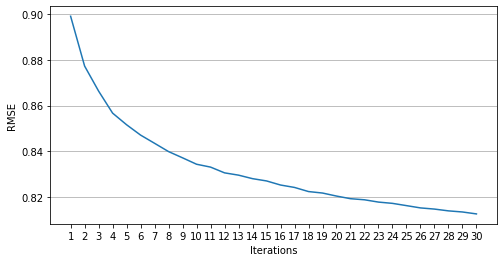

In [ ]:
# iteration에 따른 training loss

x = train_result_df.Iteration.values + 1
y = train_result_df.RMSE.values
plt.figure(figsize=((8,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.grid(axis="y")

- 학습을 거듭할 수록 오차가 줄어듦을 확인할 수 있습니다

# Matrix Factorization의 ALS 구현

1. 초기 아이템, 사용자 행렬을 초기화
2. 아이템 행렬을 고정하고, 사용자 행렬을 최적화
3. 사용자 행렬을 고정하고, 아이템 행렬을 최적화
4. 2,3 과정을 반복

In [ ]:
# 유저-아이템 행렬

R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])


In [ ]:
# 학습데이터, 하이퍼파라미터 초기화

# 잠재요인 개수
k = 5

# l2 하이퍼파라미터
regularization = 0.01
num_users, num_items = R.shape

# ALS 업데이트 횟수
iterations = 100

In [ ]:
# 유저, 아이템 잠재요인 매트릭스

users = np.random.normal(scale=1./k, size=(num_users, k))
items = np.random.normal(scale=1./k, size=(num_items, k))
items.shape

(5, 5)

- `ALS` 업데이트 수식

 $p_{u} = (Q^{T}Q + \lambda I)^{-1}Q^{T}r_{u}$ 

 $q_{i} = (P^{T}P + \lambda I)^{-1}P^{T}r_{i}$ 

In [ ]:
# iteration마다 상위에 있는 수식을 활용해 유저, 아이템을 업데이트 합니다
# 참고: https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
training_process = []
for epoch in range(iterations):
    for i, Ri in enumerate(R):
        users[i] = np.linalg.solve(np.dot(items.T, items) + regularization * np.eye(k), \
                                   np.dot(items.T, R[i].T)).T
    for j, Rj in enumerate(R.T):
        items[j] = np.linalg.solve(np.dot(users.T, users) + regularization * np.eye(k), \
                                   np.dot(users.T, R[:, j]))
    
    cost = 0
    xi, yi = R.nonzero()
    for x, y in zip(xi, yi):
        cost += pow(R[x,y] - users[x, :].dot(items[y, :].T), 2)
    
    cost = np.sqrt(cost / len(xi))
    training_process.append((epoch, cost))

    if (epoch + 1) % 10 == 0:
        print('Iteration : %d, Cost : %.4f' % (epoch + 1, cost))

Iteration : 10, Cost : 0.0012
Iteration : 20, Cost : 0.0014
Iteration : 30, Cost : 0.0016
Iteration : 40, Cost : 0.0018
Iteration : 50, Cost : 0.0019
Iteration : 60, Cost : 0.0021
Iteration : 70, Cost : 0.0022
Iteration : 80, Cost : 0.0023
Iteration : 90, Cost : 0.0024
Iteration : 100, Cost : 0.0025


In [ ]:
R

array([[1, 0, 0, 1, 3],
       [2, 0, 3, 1, 1],
       [1, 2, 0, 5, 0],
       [1, 0, 0, 4, 4],
       [2, 1, 5, 4, 0],
       [5, 1, 5, 4, 0],
       [0, 0, 0, 1, 0]])

In [ ]:
R_hat = users.dot(items.T)
R_hat

array([[ 9.98930777e-01, -4.70891456e-03,  1.32841415e-04,
         1.00246432e+00,  2.99628317e+00],
       [ 1.99989818e+00, -1.02899885e-03,  2.99825749e+00,
         1.00131843e+00,  9.98450852e-01],
       [ 9.99918861e-01,  1.99533117e+00,  1.77806308e-03,
         4.99859146e+00,  8.65619216e-04],
       [ 1.00055629e+00,  4.50183729e-03,  5.74596827e-04,
         3.99746439e+00,  3.99842214e+00],
       [ 2.00470598e+00,  9.99107091e-01,  4.99551828e+00,
         3.99866556e+00, -2.80396274e-04],
       [ 4.99486223e+00,  1.00162513e+00,  5.00149971e+00,
         4.00015323e+00,  1.40076447e-03],
       [ 3.33063481e-04,  4.14756462e-03,  3.98279293e-04,
         9.97878975e-01,  1.33676559e-03]])

## ALS Class

In [ ]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

class AlternatingLeastSquares():
    def __init__(self, R, k, regularization, iterations, verbose=False):
        """
        Arguments
        - R (ndarray)             : 유저 아이템 매트릭스
        - k (int)                 : latent factor 차원
        - reg_param (float)       : regularization parameter
        - epochs (int)            : als로 파라미터 업데이트를 수행하는 횟수
        - verbose (boolean)       : 학습 과정의 status print 옵션
        """
        self.R = R
        self.num_users, self.num_items = R.shape
        self.k = k
        self.regularization = regularization
        self.iterations = iterations
        self.verbose = verbose

    def fit(self):
        # 유저, 아이템 매트릭스 초기화
        self.users = np.random.normal(scale=1./self.k, size=(self.num_users, self.k))
        self.items = np.random.normal(scale=1./self.k, size=(self.num_items, self.k))

        # iteration 개수만큼 ALS를 수행하여 유저, 아이템 파라미터를 업데이트
        self._training_process = []
        for iteration in range(self.iterations):
            for i, Ri in enumerate(self.R):
                self.users[i] = self.user_latent(i, Ri)

            for j, Rj in enumerate(self.R.T):
                self.items[j] = self.item_latent(j, Rj)

            # iteration 수행이 끝날 때마다 training loss를 계산
            cost = self.cost()
            self._training_process.append((iteration, cost))

            # 10번째 마다 loss를 출력하는 옵션
            if self.verbose == True and ((iteration + 1) % 10 == 0):
                print('Iteration : %d, cost = %.4f' % (iteration + 1, cost))

    def cost(self):
        """
        학습 데이터 전체의 rmse 계산
        """
        xi, yi = self.R.nonzero()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self.R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost / len(xi))

    def user_latent(self, i, Ri):
        """
        유저 i에 대한 유저 벡터 업데이트
        """
        du = np.linalg.solve(np.dot(self.items.T, self.items) + self.regularization * np.eye(k), \
                             np.dot(self.items.T, self.R[i].T)).T
        return du

    def item_latent(self, j, Rj):
        """
        아이템 j에 대한 아이템 벡터 업데이트
        """

        di = np.linalg.solve(np.dot(self.users.T, self.users) + self.regularization * np.eye(self.k),
                                 np.dot(self.users.T, self.R[:, j]))
        return di

    def get_prediction(self, i, j):
        """
        유저 i, 아이템 j에 대한 예측 평점
        """
        return self.users[i, :].dot(self.items[j, :].T)
    
    def get_full_matrix(self):
        """
        예측된 유저, 아이템 매트릭스를 계산 -> hat
        """
        return self.users.dot(self.items.T)
    




In [ ]:
R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

als = AlternatingLeastSquares(R = R, regularization = 0.01, iterations=20, verbose=True, k=5)
als.fit()

Iteration : 10, cost = 0.0012
Iteration : 20, cost = 0.0014


In [ ]:
als.get_full_matrix()

array([[ 1.00023452e+00, -3.66794436e-03, -6.67044736e-04,
         1.00141119e+00,  2.99889613e+00],
       [ 2.00028053e+00, -1.16656801e-03,  2.99918686e+00,
         1.00050287e+00,  9.99629714e-01],
       [ 1.00053308e+00,  1.99723837e+00, -2.25076331e-04,
         4.99996465e+00,  2.25693861e-04],
       [ 9.99558207e-01,  3.27636302e-03,  1.03043428e-03,
         3.99896214e+00,  3.99964756e+00],
       [ 2.00263226e+00,  9.98506112e-01,  4.99759231e+00,
         3.99913509e+00,  4.10073882e-04],
       [ 4.99741288e+00,  1.00191709e+00,  5.00147413e+00,
         4.00029591e+00,  7.35893831e-05],
       [-5.00406333e-04,  3.20473221e-03,  8.81677377e-04,
         9.98953575e-01,  4.05750628e-04]])

In [ ]:
als.get_prediction(1, 3)

1.0005028735692887

# Surprise에서 제공하는 MF 모델(SVD)
- 지난 시간에 사용한 `Surprise` 패키지에서 추천 모델을 제공합니다.
    - `Surprise`의 `SVD`는 `SGD`로 학습되는 `MF`를 의미합니다.
- `SGD`로 모델이 학습될 때 변경 가능한 옵션과 하이퍼 파라미터에 대해서 살펴봅니다
- 무비렌즈 데이터를 활용해 `KNN` 모델과 `SGD` 모델을 각각 학습해보고 추천 성능을 비교합니다

> **note** 
- `Surprise` 라이브러리는 빅데이터에 적합하지 않아 현업에선 `Implicit` 라이브러리를 많이 쓰입니다.
- `Implicit` 라이브러리는 평점 예측 같은 문제에 적합한 라이브러리입니다.

In [ ]:
# surprise에서 제공하는 dataset과 reader

from surprise import Reader, Dataset

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [ ]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# train / test 데이터 나누기
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

## SVD Model
- [API 문서](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
- The SVD++ algorithm, ans extension of SVD taking into account implict ratings

In [ ]:
# SVD 모델을 사용하자 => MF의 SGD 구현을 Suprise에서 SVD로 부름

svd_model = SVD(n_factors=20, reg_all = 0.02)

# 학습데이터를 가지고 모델 학습
svd_model.fit(train_data)

# 테스트 데이터로 모델의 예측 평점을 추론
predictions = svd_model.test(test_data)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8664


0.8664319059497743

In [ ]:
# 유저/아이템 매트릭스

print(svd_model.pu.shape)
print(svd_model.qi.shape)

(610, 20)
(8933, 20)


In [ ]:
# 유저 0의 latent factor

svd_model.pu[0]

array([-0.03162712,  0.06799196, -0.1480113 ,  0.1828614 ,  0.04981814,
       -0.03793953, -0.16268918, -0.20891594,  0.05129714, -0.02390629,
       -0.09319922, -0.10102457, -0.08146522,  0.01051038,  0.04353571,
        0.08651916, -0.1206215 , -0.05691168, -0.09118009,  0.06712184])

In [ ]:
# 아이템 0의 latent factor

svd_model.qi[0]

array([-0.04725589,  0.13939436,  0.24465227,  0.05189865,  0.08225235,
        0.02411791,  0.16817012,  0.02537041, -0.22196512,  0.29229539,
        0.035809  , -0.05163026, -0.19924423, -0.11393416, -0.10748336,
        0.29529427, -0.16559536, -0.15010719,  0.21964968, -0.19493431])

In [ ]:
# 평점 예측

user_id = 1
item_id = 1

svd_model.predict(user_id, item_id)

Prediction(uid=1, iid=1, r_ui=None, est=4.652943575632211, details={'was_impossible': False})

In [ ]:
# 새로운 유저, 아이템이 등장할 경우 default_prediction를 사용

user_id = 0
item_id = 0

print(svd_model.predict(user_id, item_id).est)
print(svd_model.default_prediction())

3.5001859473397134
3.5001859473397134


![default_prediction](https://i.ibb.co/6YxrX1s/default-prediction.png)

## [모델 상세 옵션](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)
- Rating Function

 $\hat{r_{ui}} = \mu + b_{u} + b_{i} +q_{i}^{T}p_{u}$

- Objective Function
 
 $\sum_{r_{ui} \in R_{train}} (r_{ui} - \hat{ r_{ui}})^{2} + \lambda(b_{i}^{2} + b_{u}^{2} + \lVert q_{i} \rVert^{2} + \lVert p_{u} \rVert^{2})$


In [ ]:
# bias 유무에 따른 성능 비교

for biased in [False, True]:
    svd_model = SVD(biased=biased)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('biased:', biased, ',', accuracy.rmse(predictions))


RMSE: 0.9789
biased: False , 0.9789047826044626
RMSE: 0.8706
biased: True , 0.8706329917099418


In [ ]:
# latent factor 수에 따른 성능 비교

for k in [25, 50, 100, 150]:
    svd_model = SVD(n_factors=k)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('n_factors:', k, ',', accuracy.rmse(predictions))


RMSE: 0.8667
n_factors: 25 , 0.8666984282491238
RMSE: 0.8688
n_factors: 50 , 0.8687564582609828
RMSE: 0.8714
n_factors: 100 , 0.8713826760461219
RMSE: 0.8747
n_factors: 150 , 0.8746599296196037


In [ ]:
# learning rate에 따른 성능 비교

for lr_all in [.0025, .005, .001]:
    svd_model = SVD(lr_all=lr_all)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('lr_all:', lr_all, ',', accuracy.rmse(predictions))


RMSE: 0.8791
lr_all: 0.0025 , 0.8790563287862481
RMSE: 0.8711
lr_all: 0.005 , 0.8711361321305087
RMSE: 0.8935
lr_all: 0.001 , 0.8935399711120724


In [ ]:
# regularization에 따른 성능 비교

for reg_all in [0, 0.02, 0.1, 1]:
    svd_model = SVD(reg_all=reg_all)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('reg_all:', reg_all, ',', accuracy.rmse(predictions))


RMSE: 0.8924
reg_all: 0 , 0.8924009952634795
RMSE: 0.8702
reg_all: 0.02 , 0.8701994947949394
RMSE: 0.8672
reg_all: 0.1 , 0.8671996903501925
RMSE: 0.9051
reg_all: 1 , 0.905111827173132


In [ ]:
# Grid Search 패키지를 제공함 -> 전체적인 성능을 파악

from surprise.model_selection import GridSearchCV

grid = {'lr_all': [.0025, .005], 
        'n_factors': [25, 50, 100],
        'reg_all': [0.02, 0.1]
       }

gs = GridSearchCV(SVD, grid, measures=['RMSE'], cv=2)
gs.fit(data)

In [ ]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse')

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_lr_all,param_n_factors,param_reg_all
7,0.881839,0.882603,0.882221,0.000382,1,1.348536,0.017006,0.487085,0.086491,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.10
9,0.882273,0.882549,0.882411,0.000138,2,1.850230,0.013198,0.541217,0.008924,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.10
11,0.882671,0.883444,0.883058,0.000387,3,2.817940,0.011918,0.495511,0.053485,"{'lr_all': 0.005, 'n_factors': 100, 'reg_all':...",0.0050,100,0.10
6,0.883597,0.884501,0.884049,0.000452,4,1.335591,0.000157,0.629150,0.053933,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.02
8,0.885795,0.886343,0.886069,0.000274,5,1.845938,0.009005,0.431320,0.077859,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.02
0,0.889489,0.890560,0.890024,0.000535,6,1.400879,0.009904,0.503549,0.037052,"{'lr_all': 0.0025, 'n_factors': 25, 'reg_all':...",0.0025,25,0.02
10,0.890265,0.889792,0.890028,0.000236,7,2.823496,0.001593,0.477577,0.065614,"{'lr_all': 0.005, 'n_factors': 100, 'reg_all':...",0.0050,100,0.02
1,0.889541,0.891358,0.890450,0.000909,8,1.363721,0.012419,0.518271,0.120374,"{'lr_all': 0.0025, 'n_factors': 25, 'reg_all':...",0.0025,25,0.10
3,0.890312,0.891557,0.890935,0.000623,9,1.837487,0.016244,0.460543,0.101539,"{'lr_all': 0.0025, 'n_factors': 50, 'reg_all':...",0.0025,50,0.10
2,0.890323,0.892249,0.891286,0.000963,10,1.849634,0.015368,0.552868,0.005655,"{'lr_all': 0.0025, 'n_factors': 50, 'reg_all':...",0.0025,50,0.02


In [ ]:
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8822208629114141}
{'rmse': {'lr_all': 0.005, 'n_factors': 25, 'reg_all': 0.1}}


## 예측 모델간 성능 비교
- `KNN`과 MF`SGD` 사이의 모델 성능을 비교합니다
- `RMSE`만 봐도 MF`SGD`가 우수한 것을 확인할 수 있습니다.

In [ ]:
# KNN 모델

sim_options = {
    'name': 'msd',
    'user_based': False
}

knn = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8996  0.8949  0.8882  0.8989  0.8843  0.8932  0.0060  
MAE (testset)     0.6864  0.6822  0.6804  0.6864  0.6751  0.6821  0.0042  
Fit time          7.01    5.67    5.22    6.66    5.37    5.98    0.72    
Test time         9.24    9.98    9.21    9.81    9.46    9.54    0.31    


{'fit_time': (7.011305570602417,
  5.665681838989258,
  5.2156007289886475,
  6.657697677612305,
  5.367852449417114),
 'test_mae': array([0.68640186, 0.68223646, 0.68043021, 0.68643921, 0.67505536]),
 'test_rmse': array([0.89960218, 0.89494571, 0.88819082, 0.89888232, 0.88434879]),
 'test_time': (9.237936973571777,
  9.984932899475098,
  9.209844589233398,
  9.813077688217163,
  9.460415840148926)}

In [ ]:
# SVD 모델

svd = SVD(n_factors=25, lr_all=0.005, reg_all=0.1)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8682  0.8681  0.8803  0.8664  0.8690  0.8704  0.0050  
MAE (testset)     0.6672  0.6671  0.6779  0.6649  0.6698  0.6694  0.0045  
Fit time          2.28    2.33    2.32    2.35    2.32    2.32    0.02    
Test time         0.22    0.36    0.15    0.14    0.30    0.23    0.08    


{'fit_time': (2.284034252166748,
  2.32779860496521,
  2.3226559162139893,
  2.3528451919555664,
  2.3222243785858154),
 'test_mae': array([0.66719123, 0.66711976, 0.67788747, 0.66492328, 0.66982306]),
 'test_rmse': array([0.86824331, 0.86811143, 0.88034926, 0.86639539, 0.86902775]),
 'test_time': (0.21819424629211426,
  0.35759925842285156,
  0.14906692504882812,
  0.14101266860961914,
  0.30057573318481445)}

# Implicit와 annoy를 활용한 서빙

In [5]:
import os
import pandas as pd
import seaborn as sns
import scipy
from scipy import sparse
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

## [Implicit Library](https://github.com/benfred/implicit)


- `ALS`를 직접 구현해 봤지만 실제 프로덕션에 사용하기에 더 좋은 라이브러리가 존재합니다.
- 학습 속도를 최적화한 `Implicit` 라이브러리가 그 예

## Implicit Feedback 데이터 활용

- UCI 데이터는 1강에서 봤듯이 사용자의 상품 구매 데이터로 이루어져 있습니다.
- 무비렌즈와 달리 아이템에 대한 평점 없이 구매 이력 데이터만 존재합니다.
- 해당 데이터를 `Matrix Factorization`에 적합하게 가공하고, 모델 학습을 통한 성능을 확인해봅니다.

In [6]:
# 데이터 로드
file_path = '/content/drive/MyDrive/Colab_Notebook/learning_spoons_recommendation_system/data/online_retail/online_retail.csv'
parse_date = lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M')
retail_df = pd.read_csv(file_path, encoding="utf-8", parse_dates = ['InvoiceDate'], date_parser = parse_date)

In [4]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


- 사용자 아이디가 없는 데이터, `quantity`가 음수인 데이터를 제외합니다.

In [8]:
cleaned_retail_df = retail_df[~(retail_df['CustomerID'].isnull()) & (retail_df['Quantity'] > 0)]

- 여기서 필요한 필드만 추출합니다.

In [10]:
cleaned_retail_df['CustomerID'] = cleaned_retail_df.CustomerID.astype(int)
cleaned_retail_df = cleaned_retail_df[['StockCode', 'Quantity', 'CustomerID', 'InvoiceDate']]

In [11]:
cleaned_retail_df

,StockCode,Quantity,CustomerID,InvoiceDate
0,85123A,6,17850,2010-12-01 08:26:00
1,71053,6,17850,2010-12-01 08:26:00
2,84406B,8,17850,2010-12-01 08:26:00
3,84029G,6,17850,2010-12-01 08:26:00
4,84029E,6,17850,2010-12-01 08:26:00
...,...,...,...,...
541904,22613,12,12680,2011-12-09 12:50:00
541905,22899,6,12680,2011-12-09 12:50:00
541906,23254,4,12680,2011-12-09 12:50:00
541907,23255,4,12680,2011-12-09 12:50:00


## Train / Test 데이터 나누기

- 보통 실습자료에서 `train` 데이터와 `test` 데이터는 전체 데이터를 기반으로 랜덤하게 나눕니다.
- 하지만 실제로는 과거 데이터를 가지고 미래 데이터를 예측하기 때문에, 특정한 시간을 기준으로 전후 데이터를 `train`/`test` 데이터로 나눕니다.
- 특히 커머스 데이터와 같은 경우, 같은 상품을 다시 구매할 수 있기 때문에 이미 구매한 상품을 다시 추천하기도 합니다.

In [12]:
# 연도, 월을 추출
cleaned_retail_df['ym'] = cleaned_retail_df['InvoiceDate'].apply(lambda x: str(x)[:7])

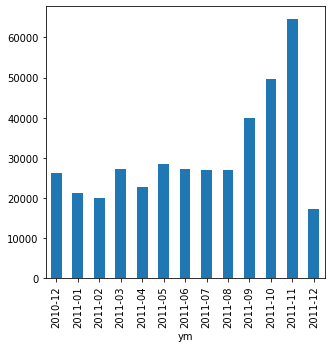

In [13]:
cleaned_retail_df.groupby(['ym'])['StockCode'].count().plot.bar(figsize=(5,5))

- 2011-10 까지의 데이터를 `train` 데이터로 사용하고, 2011-11 이후의 데이터를 `test` 데이터로 사용합니다.

In [14]:
train_df = cleaned_retail_df[cleaned_retail_df['ym'] <= '2011-10']
test_df = cleaned_retail_df[cleaned_retail_df['ym'] > '2011-10']

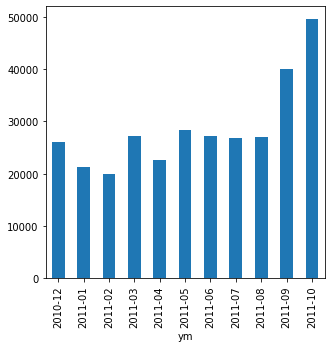

In [15]:
# train 데이터는 2010-12 ~ 2011-10
train_df.groupby(['ym'])['StockCode'].count().plot.bar(figsize=(5,5))

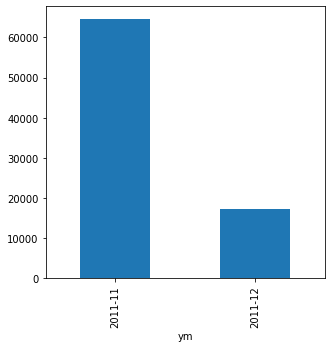

In [16]:
# test 데이터는 2011-11 ~ 2011-12
test_df.groupby(['ym'])['StockCode'].count().plot.bar(figsize=(5,5))

- 기간동안 구매한 사용자별로 구매한 아이템은 `groupby` 해서 `quantity`를 구합니다.

In [17]:
train_df = train_df.groupby(['CustomerID', 'StockCode']).sum().reset_index()    # Grouping
test_df = test_df.groupby(['CustomerID', 'StockCode']).sum().reset_index()    # Grouping

- `Implicit` 라이브러리에 적용하기 위해서 사용자 ID와 아이템 ID를 category type으로 만들어 줍니다.

In [18]:
train_df['CustomerID'] = train_df['CustomerID'].astype("category")
train_df['StockCode'] = train_df['StockCode'].astype("category")
train_df['user_id'] = train_df['CustomerID'].cat.codes
train_df['item_id'] = train_df['StockCode'].cat.codes

In [19]:
# 새로운 user_id => 기존 CustomerID
user_id_map = dict(enumerate(train_df['CustomerID'].cat.categories))
# 새로운 item_id => 기존 StockCode
item_id_map = dict(enumerate(train_df['StockCode'].cat.categories))

train_user_list = list(user_id_map.values())
item_user_list = list(item_id_map.values())

In [20]:
user_id_map

{0: 12346,
 1: 12347,
 2: 12348,
 3: 12350,
 4: 12352,
 5: 12353,
 6: 12354,
 7: 12355,
 8: 12356,
 9: 12358,
 10: 12359,
 11: 12360,
 12: 12361,
 13: 12362,
 14: 12363,
 15: 12364,
 16: 12365,
 17: 12370,
 18: 12371,
 19: 12372,
 20: 12373,
 21: 12375,
 22: 12377,
 23: 12378,
 24: 12379,
 25: 12380,
 26: 12381,
 27: 12383,
 28: 12384,
 29: 12386,
 30: 12388,
 31: 12390,
 32: 12393,
 33: 12394,
 34: 12395,
 35: 12397,
 36: 12398,
 37: 12399,
 38: 12401,
 39: 12402,
 40: 12403,
 41: 12405,
 42: 12406,
 43: 12407,
 44: 12408,
 45: 12409,
 46: 12410,
 47: 12412,
 48: 12413,
 49: 12414,
 50: 12415,
 51: 12417,
 52: 12418,
 53: 12420,
 54: 12421,
 55: 12422,
 56: 12423,
 57: 12424,
 58: 12425,
 59: 12426,
 60: 12427,
 61: 12428,
 62: 12429,
 63: 12430,
 64: 12431,
 65: 12432,
 66: 12433,
 67: 12434,
 68: 12435,
 69: 12436,
 70: 12437,
 71: 12438,
 72: 12441,
 73: 12444,
 74: 12446,
 75: 12447,
 76: 12448,
 77: 12449,
 78: 12450,
 79: 12451,
 80: 12453,
 81: 12454,
 82: 12455,
 83: 12456,
 8

- 나중에 `test` 데이터를 가지고 유저별로 성능을 평가할 때 사용합니다.

In [23]:
# 기존 CustomerID => 새로운 user_id
customer_id_map = dict()
# 기존 StockCode => 새로운 item_id
stock_code_map = dict()

for x, y in zip(user_id_map.keys(), user_id_map.values()):
    customer_id_map[y] = x

for x, y in zip(item_id_map.keys(), item_id_map.values()):
    stock_code_map[y] = x

In [24]:
stock_code_map

{'10002': 0,
 '10080': 1,
 '10120': 2,
 '10123C': 3,
 '10124A': 4,
 '10124G': 5,
 '10125': 6,
 '10133': 7,
 '10135': 8,
 '11001': 9,
 '15030': 10,
 '15034': 11,
 '15036': 12,
 '15039': 13,
 '15044A': 14,
 '15044B': 15,
 '15044C': 16,
 '15044D': 17,
 '15056BL': 18,
 '15056N': 19,
 '15056P': 20,
 '15058A': 21,
 '15058B': 22,
 '15058C': 23,
 '15060B': 24,
 '16008': 25,
 '16010': 26,
 '16011': 27,
 '16012': 28,
 '16014': 29,
 '16015': 30,
 '16016': 31,
 '16020C': 32,
 '16033': 33,
 '16043': 34,
 '16045': 35,
 '16046': 36,
 '16048': 37,
 '16049': 38,
 '16052': 39,
 '16054': 40,
 '16151A': 41,
 '16156L': 42,
 '16156S': 43,
 '16161G': 44,
 '16161M': 45,
 '16161P': 46,
 '16161U': 47,
 '16162L': 48,
 '16162M': 49,
 '16168M': 50,
 '16169E': 51,
 '16169K': 52,
 '16169M': 53,
 '16169N': 54,
 '16169P': 55,
 '16202A': 56,
 '16202B': 57,
 '16202E': 58,
 '16206B': 59,
 '16207A': 60,
 '16207B': 61,
 '16216': 62,
 '16218': 63,
 '16219': 64,
 '16225': 65,
 '16235': 66,
 '16236': 67,
 '16237': 68,
 '16238

- 학습할 유저-아이템 매트릭스입니다.
 - 이때 평점 대신 어떤 값을 넣는가?
 - 유저가 아이템을 구매한 횟수를 $r_ui$로 사용합니다.\
 - `sparse`의 경우, 없는 값은 생략하기 때문에 `numpy`에 import하려면 아래와 같은 후처리가 필요합니다.

In [9]:
sparse_user_item = sparse.csr_matrix((train_df['Quantity'].astype(float), 
                                      (train_df['user_id'], train_df['item_id'])))

NameError: ignored

In [27]:
sparse_user_item

<3974x3613 sparse matrix of type '<class 'numpy.float64'>'
	with 221390 stored elements in Compressed Sparse Row format>

In [28]:
# 유저-아이템 매트릭스의 가능한 모든 개수
matrix_size = sparse_user_item.shape[0] * sparse_user_item.shape[1]
# 유저-아이템 entry가 실제로 존재하는 개수
num_purchases = len(sparse_user_item.nonzero()[0])
sparsity = 100 * (1 - (num_purchases / matrix_size))
sparsity

98.45807881314344

## [ALS](https://implicit.readthedocs.io/en/latest/als.html) 모델 학습 및 평가

In [30]:
!pip install implicit

     |████████████████████████████████| 1.1MB 3.9MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406404 sha256=488a2be3b5e575e38624481e5ce523028e1a56ae547c9db18948e028f8cc94f2
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [8]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=100)

# alpha는 'Collaborative Filtering for Implicit Feedback Datasets' 논문에서 소개된 confidence 값
# 그때그때 수치가 다름

alpha = 1

model.fit(alpha * sparse_user_item.T)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


NameError: ignored

In [32]:
user_vecs = model.user_factors
item_vecs = model.item_factors
print(user_vecs.shape)
print(item_vecs.shape)

(3974, 32)
(3613, 32)


- 유저 0에게 가장 적합한 아이템 10개를 추천해봅니다.

In [33]:
[(item, score) for item, score in model.recommend(0, sparse_user_item.T, 10)]

[(454, 0.0012171512),
 (2833, 0.0012107218),
 (1369, 0.0011935254),
 (3537, 0.0011774022),
 (1892, 0.0011761462),
 (1147, 0.001172248),
 (1871, 0.0011544863),
 (714, 0.0011534388),
 (2267, 0.001149536),
 (1988, 0.0011492274)]

## Top N Recommendation

- Precision@K, Recall@K로 성능을 평가합니다.

In [35]:
k = 20

# training data에 user가 없는 경우엔 추천이 안되므로 인기도 기반 추천 리스트를 미리 만들어 놓습니다.
popular_item_at_k = list(train_df.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)

precisions = []
recalls = []

# 사용자 별로 Top N 추천을 하여 사용자 별 precision, recall을 구합니다.

cold_start = 0
user_grouped = test_df.groupby('CustomerID')
for customer_id, user_df in tqdm(user_grouped):
    # test 데이터는 존재하는 사용자가 이미 구매한 아이템 = 정답
    buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                 for stock_code in user_df['StockCode'].unique()]
    
    if customer_id in customer_id_map:
        user_id = customer_id_map[customer_id]
        user_vector = model.user_factors[user_id]
        scores = item_vecs.dot(user_vector)
        top_k_item = np.argpartition(scores, -k)[-k:]

        # 모델에서 top k 아이템을 선정하는 함수를 이미 제공
        # top_k_item = [item for item, _ in model.recommend(user_id, sparse_user_item.T, k, filter_already_liked_items=False)]
    else:
        cold_start += 1
        top_k_item = popular_item_at_k    

    intersect = set(buy_items).intersection(set(top_k_item))

    precision = len(intersect) / len(top_k_item)
    recall = len(intersect) / len(buy_items)

    precisions.append(precision)
    recalls.append(recall)

print('precision@k:', np.mean(np.asarray(precisions)))
print('recall@k:', np.mean(np.asarray(recalls)))
print('cold_start_user:', cold_start)

100%|██████████| 1909/1909 [00:01<00:00, 1878.79it/s]

precision@k: 0.012755369303300158
recall@k: 0.010620371390179552
cold_start_user: 365


- 다음은 간단한 Grid Search입니다.

In [37]:
grid_search_result = []

for factors in [10, 20, 40]:
    for alpha in [1, 5, 10]:
        # 모델 학습
        model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=0.1, iterations=100)
        model.fit(alpha * sparse_user_item.T)

        user_vecs = model.user_factors
        item_vecs = model.item_factors

        # 모델 평가
        k = 20
        popular_item_at_k = list(train_df.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)
        precisions = []
        recalls = []

        user_grouped = test_df.groupby('CustomerID')
        for customer_id, user_df in user_grouped:
            buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                         for stock_code in user_df['StockCode'].unique()]

            if customer_id in cutomer_id_map:
                user_id = customer_id_map[customer_id]
                user_vector = model.user_factors[user_id]
                scores = item_vec.dot(user_vector)
                top_k_item = np.argpartition(scores, -k)[-k:]
            else:
                top_k_item = popular_item_at_k

            intersect = set(buy_items).intersect(set(top_k_item))

            precision = len(intersect)/len(top_k_item)
            recall = len(intersect)/len(buy_items)

            precisions.append(precision)
            recalls.append(recall)

        print("factors:", factors, "alpha", alpha)
        print('precision@k:', np.mean(np.asarray(precisions)))
        print('recall@k:', np.mean(np.asarray(recalls)))
        grid_search_result.append([factors, alpha, np.mean(np.asarray(precisions)), np.mean(np.asarray(recalls))])

RuntimeError: ignored

In [38]:
pd.DataFrame(grid_search_result,
             columns = ['factors', 'alpha', 'precision@k', 'recall@k']).sort_values(by='precision@k', ascending=False)

,factors,alpha,precision@k,recall@k


## [BPR](https://implicit.readthedocs.io/en/latest/bpr.html) 모델 학습 및 평가

In [7]:
factors = 40
model = implicit.bpr.BayesianPersonalizedRanking(factors=factors, regularization=0.01, iterations=5000)

# BPR에는 alpha가 없음
model.fit(sparse_user_item.T)

user_vecs = model.user_factors
item_vecs = model.item_factors

NameError: ignored

In [2]:
k = 20

# training data에 user가 없는 경우엔 추천이 안되므로 인기도 기반 추천 리스트를 미리 만들어 놓는다.
popular_item_at_k = list(train_df.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)

precisions = []
recalls = []

# 사용자 별로 Top N 추천을 하여 사용자 별 precision recall을 구한다.

cold_start = 0
user_grouped = test_df.groupby('CustomerID')
for customer_id, user_df in tqdm(user_grouped):
    
    # test 데이터에 존재하는 사용자가 이미 구매한 아이템 = 정답
    buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                 for stock_code in user_df['StockCode'].unique()]
    
    if customer_id in customer_id_map:
        
        user_id = customer_id_map[customer_id]
        user_vector = model.user_factors[user_id]
        scores = item_vecs.dot(user_vector)
        top_k_item = np.argpartition(scores, -k)[-k:]

        # 모델에서 top k 아이템을 선정하는 함수를 이미 제공함
        # top_k_item = [item for item, _ in model.recommend(user_id, sparse_user_item.T, k, filter_already_liked_items=False)]

    else:
        cold_start += 1
        top_k_item = popular_item_at_k
        
    intersect = set(buy_items).intersection(set(top_k_item))
    
    precision = len(intersect)/len(top_k_item)
    recall = len(intersect)/len(buy_items)
    
    precisions.append(precision)
    recalls.append(recall)
    
print('precision@k:', np.mean(np.asarray(precisions)))
print('recall@k:', np.mean(np.asarray(recalls)))
print('cold_start_user:', cold_start)

NameError: ignored

In [3]:
# 간단한 grid search

grid_search_result = []

for factors in [10, 20, 40]:
    for alpha in [1, 5, 10]:
        
        # 모델 학습
        model = implicit.als.AlternatingLeastSquares(factors=factors, regularization = 0.1, iterations = 100)
        model.fit(alpha * sparse_user_item.T)
        
        user_vecs = model.user_factors
        item_vecs = model.item_factors
        
        # 모델 평가
        k = 20        
        popular_item_at_k = list(train_df.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)
        precisions = []
        recalls = []

        user_grouped = test_df.groupby('CustomerID')
        for customer_id, user_df in user_grouped:

            buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                         for stock_code in user_df['StockCode'].unique()]

            if customer_id in customer_id_map:
                user_id = customer_id_map[customer_id]
                user_vector = model.user_factors[user_id]
                scores = item_vecs.dot(user_vector)
                top_k_item = np.argpartition(scores, -k)[-k:]

            else:
                top_k_item = popular_item_at_k

            intersect = set(buy_items).intersection(set(top_k_item))

            precision = len(intersect)/len(top_k_item)
            recall = len(intersect)/len(buy_items)

            precisions.append(precision)
            recalls.append(recall)

        print("factors:", factors, "alpha", alpha)
        print('precision@k:', np.mean(np.asarray(precisions)))
        print('recall@k:', np.mean(np.asarray(recalls)))
        grid_search_result.append([factors, alpha, np.mean(np.asarray(precisions)), np.mean(np.asarray(recalls))])


NameError: ignored

In [4]:
pd.DataFrame(grid_search_result,
             columns = ['factors', 'alpha', 'precision@k', 'recall@k']).sort_values(by='precision@k', ascending=False)

NameError: ignored

## [Annoy](https://github.com/spotify/annoy)를 활용한 빠른 서빙


- 추천해야 할 아이템 숫자가 굉장히 많아질 경우 실시간 서빙에는 어려움이 따릅니다.
- 만약 배치로 서빙 결과를 모두 만들어 준비해 놓는다면 문제가 없으나, 그렇지 않은 경우 서빙 속도는 정확도보다 더 중요할 수 있습니다.
- `Annoy`를 활용해서 추천의 정확도를 다소 포기하는 대신, 짧은 `latency`를 얻을 수 있습니다.
- `nmslib`, `faiss`를 구하는 경우가 더 많긴 합니다.

In [10]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=20, regularization = 0.1, iterations = 100)
alpha = 1

model.fit(alpha * sparse_user_item.T)

NameError: ignored

In [11]:
user_vecs = model.user_factors
item_vecs = model.item_factors
print(user_vecs.shape)
print(item_vecs.shape)

AttributeError: ignored

## 주어진 아이템과 비슷한 아이템을 추천하는 Task

In [ ]:
# 기존 방식대로 모든 아이템에 대해서 유사도를 계산하고 정렬해서 top n개를 추출해봅시다

itemid = 0
N = 20

# cosine 유사도를 구하기 위해서는 모든 아이템 벡터의 norm을 구해야 합니다
item_norms = np.linalg.norm(item_vecs, axis=-1)
item_norms[item_norms == 0] = 1e-10

# 주어진 아이템 벡터와 norm
target_item_vec = item_vecs[itemid]
target_item_norm = item_norms[0]

In [ ]:
# score는 cosine 유사도이며 유사도가 클수록 주어진 아이템과 비슷하다는 의미입니다
scores = item_vecs.dot(target_item_vec) / (target_item_norm * item_norms)

# score가 높은 아이템 N개 추출
best = np.argpartition(scores, -N)[-N:]
sorted(zip(best.tolist(), scores[best].tolist()), key=lambda x: -x[1])

[(0, 0.9999998807907104),
 (2708, 0.7340555191040039),
 (2354, 0.7028123736381531),
 (2707, 0.684908926486969),
 (1647, 0.6814053058624268),
 (599, 0.6785038113594055),
 (1599, 0.6638332009315491),
 (2072, 0.6475762128829956),
 (633, 0.6472743153572083),
 (2711, 0.6465908885002136),
 (1987, 0.6375262141227722),
 (2774, 0.6310957074165344),
 (1664, 0.6242886781692505),
 (2245, 0.6040313839912415),
 (1155, 0.5887247323989868),
 (1285, 0.5847207903862),
 (4, 0.583721399307251),
 (2247, 0.5835863947868347),
 (2246, 0.579708456993103),
 (2248, 0.5797083973884583)]

In [ ]:
# annoy를 사용해 tree를 만들어봅니다

import annoy

# annoy의 파라미터, tree의 개수가 많아질수록 appoximate의 정확도가 올라갑니다. 대신의 탐색 속도는 더 느려집니다
n_trees = 20

# angular는 cosine 유사도와 거의 유사합니다
# https://en.wikipedia.org/wiki/Cosine_similarity#Angular_distance_and_similarity
similar_items_index = annoy.AnnoyIndex(item_vecs.shape[1], "angular")

# 모든 아이템 벡터를 annoy에 넣습니다
for i, row in enumerate(item_vecs):
    similar_items_index.add_item(i, row)
    
# annoy 모델을 build 합니다
similar_items_index.build(n_trees)

True

In [ ]:
# annoy 안에 있는 전체 아이템 개수
similar_items_index.get_n_items()

3613

In [ ]:
# 0번 아이템과 유사한 아이템을 annoy를 활용해서 추천해봅시다

itemid = 0
N = 20

neighbours, dist = similar_items_index.get_nns_by_item(itemid, N, include_distances=True)

In [ ]:
[(x, y) for x, y in zip(neighbours, dist)]

[(0, 0.0),
 (2708, 0.729307234287262),
 (2354, 0.770957350730896),
 (2707, 0.7938399910926819),
 (1647, 0.798241376876831),
 (599, 0.8018680214881897),
 (2072, 0.8395520448684692),
 (633, 0.8399114608764648),
 (2711, 0.8407247066497803),
 (1987, 0.8514385223388672),
 (2774, 0.8589580059051514),
 (1664, 0.86684650182724),
 (2245, 0.8899086117744446),
 (1155, 0.9069457054138184),
 (1285, 0.911349892616272),
 (4, 0.9124457836151123),
 (2247, 0.9125936627388),
 (2248, 0.916833221912384),
 (2246, 0.916833221912384),
 (3071, 0.9290491938591003)]

## 유저에게 아이템 추천

In [ ]:
# 123번 유저에게 als 모델을 활용해서 추천을 수행합니다

user_id = 123
N = 20

# model.recommend method 사용
[(item, score) for item, score in model.recommend(user_id, sparse_user_item.T, N)]

[(168, 1.1601238),
 (422, 1.157624),
 (169, 1.1485097),
 (423, 1.1061195),
 (1229, 1.1038591),
 (172, 1.0713097),
 (166, 1.0701532),
 (3095, 1.060375),
 (340, 1.0564672),
 (908, 1.0374653),
 (2034, 1.031428),
 (2123, 1.0278089),
 (907, 1.0254319),
 (3096, 1.024255),
 (165, 1.0212393),
 (1251, 1.0172818),
 (170, 1.0155588),
 (2032, 1.0149515),
 (909, 1.0127441),
 (363, 1.0120344)]

In [ ]:
# annoy를 사용해 tree를 만들어봅니다

import annoy

# annoy의 파라미터
# tree의 개수가 많아질수록 appoximate의 정확도가 올라갑니다. 대신의 탐색 속도는 더 느려집니다
n_trees = 20

# 유저 - 아이템은 dot product를 사용합니다
# 유저 벡터와 아이템의 dot product가 MF 추천 모델의 스코어 이기 때문입니다.
user_items_index = annoy.AnnoyIndex(item_vecs.shape[1], "dot")

# 모든 아이템 벡터를 annoy에 넣습니다
for i, row in enumerate(item_vecs):
    user_items_index.add_item(i, row)
    
# annoy 모델을 build 합니다
user_items_index.build(n_trees)

True

In [ ]:
# 123번 유저과 유사한 아이템을 annoy를 활용해서 추천해봅시다

user_id = 123
N = 20

neighbours, dist = user_items_index.get_nns_by_vector(user_vecs[user_id], N, include_distances=True)

In [ ]:
[(x, y) for x, y in zip(neighbours, dist)]

[(168, 1.1601238250732422),
 (422, 1.1576240062713623),
 (169, 1.1485097408294678),
 (1229, 1.1038590669631958),
 (172, 1.0713096857070923),
 (166, 1.0701531171798706),
 (340, 1.0564671754837036),
 (908, 1.037465214729309),
 (2034, 1.0314280986785889),
 (165, 1.0212392807006836),
 (1251, 1.0172816514968872),
 (170, 1.0155589580535889),
 (2032, 1.014951467514038),
 (363, 1.0120344161987305),
 (1252, 1.010757565498352),
 (1253, 1.0017695426940918),
 (2037, 0.9880431890487671),
 (1228, 0.9796099662780762),
 (171, 0.9793617725372314),
 (3184, 0.972058117389679)]

## annoy 서빙의 속도 비교

In [ ]:
N = 20

mf_serving = list()
annoy_serving= list()

for i in range(1000):
    
    # 랜덤하게 아이템 선택
    itemid = random.sample([i for i in range(item_vecs.shape[0])], 1)[0]
    
    # annoy를 활용하지 않은 서빙
    mf_now = datetime.now()
    item_norms = np.linalg.norm(item_vecs, axis=-1)
    item_norms[item_norms == 0] = 1e-10
    target_item_vec = item_vecs[itemid]
    target_item_norm = item_norms[itemid]
    scores = item_vecs.dot(target_item_vec) / (target_item_norm * item_norms)
    topN = np.argpartition(scores, -N)[-N:]
    mf_serving.append((datetime.now() - mf_now).microseconds)
    
    # annoy를 활용한 서빙
    annoy_now = datetime.now()
    topN, dist = similar_items_index.get_nns_by_item(itemid, N, include_distances=True)
    
    annoy_serving.append((datetime.now() - annoy_now).microseconds)

    
print("mf serving: ", np.mean(np.asarray(mf_serving)))
print("annoy serving: ", np.mean(np.asarray(annoy_serving)))

mf serving:  150.22
annoy serving:  52.116


## annoy implemented ALS
- 유저에게 아이템을 추천할 때도 annoy를 활용하여 빠르게 서빙할 수 있습니다
- implict library에서 직접 annoy가 구현된 als matrix factorization을 제공합니다

In [ ]:
import implicit

# initialize a annoy als model
# https://implicit.readthedocs.io/en/latest/ann.html

# annoy가 적용된 ALS 모델
# 실제 학습은 동일하지만 추천 서빙 annoy를 활용하여 합니다
annoy_model = implicit.approximate_als.AnnoyAlternatingLeastSquares(
    approximate_similar_items=True, approximate_recommend=True, n_trees=100,
    factors=20, regularization = 0.1, iterations = 100
)

alpha = 1
annoy_model.fit(alpha * sparse_user_item.T)

# 기존 ALS 모델
als_model = implicit.als.AlternatingLeastSquares(factors=20, regularization = 0.1, iterations = 100)

alpha = 1
als_model.fit(alpha * sparse_user_item.T)

In [ ]:
# 모델 평가

k = 20        
popular_item_at_k = list(train_df.groupby('item_id')['Quantity'].sum().sort_values(ascending=False)[:k].index)

# 유저별로 평가하기 위해 그룹핑
user_grouped = test_df.groupby('CustomerID')

# annoy als 모델과 als 모델에 대해 성능을 비교해봅시다
for model in [annoy_model, als_model]:
    
    precisions = []
    recalls = []

    # 유저별로 precision / recall 성능을 평가함
    for customer_id, user_df in user_grouped:
        
        # test 데이터에 있는 유저가 실제로 구매한 아이템
        buy_items = [stock_code_map[stock_code] if stock_code in stock_code_map else stock_code \
                     for stock_code in user_df['StockCode'].unique()]
        
        # train 데이터에 유저가 존재하는 경우
        if customer_id in customer_id_map:
            user_id = customer_id_map[customer_id]
            top_k_item = [id for id, score in model.recommend(user_id, sparse_user_item, N=k, filter_already_liked_items=False)]

        # train 데이터에 유저가 없는 경우
        else:
            top_k_item = popular_item_at_k
        
        # 추천 아이템 가운데 유저가 실제로 구매한 아이템 집합
        intersect = set(buy_items).intersection(set(top_k_item))
        
        # 성능 측정
        precision = len(intersect)/len(top_k_item)
        recall = len(intersect)/len(buy_items)

        precisions.append(precision)
        recalls.append(recall)
    
    print(model.__class__.__name__)
    print('precision@k:', np.mean(np.asarray(precisions)))
    print('recall@k:', np.mean(np.asarray(recalls)))

AnnoyAlternatingLeastSquares
precision@k: 0.10225248821372446
recall@k: 0.09543053318185349
AlternatingLeastSquares
precision@k: 0.11998428496595076
recall@k: 0.11839843914531509
